# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, action_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    actions_logits = tf.placeholder(tf.float32, [None, action_size], name='actions_logits')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, actions_logits, states, next_states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Generator/Autorencoder/Adv
def G(states, actions_logits, state_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('G', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = tf.concat([h, actions_logits], axis=1)
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        next_states_ = mlp(inputs=h, units=state_size)
        return next_states_

In [14]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions_ = mlp(inputs=h, units=action_size)
        return actions_

In [15]:
def model_loss(actions, actions_logits, states, next_states, targetQs, state_size, action_size, hidden_size, 
               is_training=False):

    next_states_ = G(states=states, actions_logits=actions_logits, hidden_size=hidden_size, 
                     state_size=state_size, is_training=is_training)
    
    gloss = tf.reduce_mean(tf.reduce_sum((next_states - next_states_)**2, axis=1))

    actions_logits_ = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                        is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits_.dtype)
    
    Qs = tf.reduce_max(actions_logits_ * actions_labels, axis=1)
    
    dloss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits_, next_states_, gloss, dloss

In [16]:
def model_opt(gloss, dloss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(dloss, var_list=d_vars)

    return g_opt, d_opt

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.actions, self.actions_logits, self.states, self.next_states, self.targetQs, \
         self.is_training) = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits_, self.next_states_, self.gloss, self.dloss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, next_states=self.next_states, 
            actions=self.actions, actions_logits=self.actions_logits,
            targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [20]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [22]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    actions_logits = np.array([each[5] for each in batch])
    
    next_actions_logits_ = sess.run(model.actions_logits_, feed_dict = {model.states: next_states, 
                                                                        model.is_training: False})
    
    nextQs = np.max(next_actions_logits_, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    feed_dict = {model.states: states, model.actions: actions, model.actions_logits: actions_logits,
                 model.next_states: next_states, model.targetQs: targetQs, model.is_training: False}
    
    dloss, _ = sess.run([model.dloss, model.d_opt], feed_dict)
    gloss, _ = sess.run([model.gloss, model.g_opt], feed_dict)
                                                             
    return gloss, dloss

In [24]:
def env_(sess, state, action_logits):
    
    next_state_ = sess.run(model.next_states_, feed_dict={
        model.states: state.reshape([1, -1]), 
        model.actions_logits: action_logits.reshape([1, -1]),
        model.is_training: False})
    
    return next_state_.reshape(-1)

In [25]:
def act(sess, state):
    
    action_logits_ = sess.run(model.actions_logits_, feed_dict={model.states: state.reshape([1, -1]), 
                                                                model.is_training: False})
    
    action = np.argmax(action_logits_, axis=1)[0]
    #print(action)
    
    return action, action_logits_.reshape(-1)

In [26]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action, action_logits = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done), action_logits])
            
            # Explore (Env) or Exploit (Model)
            #total_step += 1
            #explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            explore_p = np.random.normal(0, 1)
            if np.abs(explore_p) < 1e-3:
                print('np.abs(explore_p) < 1e-3:', explore_p)
                next_state = env_(sess, state=state, action_logits=action_logits)
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                gloss, dloss = learn(sess, memory, batch_size)
                loss_batch.append([gloss, dloss])
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)

            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'gloss:{:.4f}'.format(np.mean(loss_batch[0])),
                  'dloss:{:.4f}'.format(np.mean(loss_batch[1])))
            
            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
        
        else: print('len(memory.buffer) >= batch_size:', len(memory.buffer), batch_size)
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

len(memory.buffer) >= batch_size: 15 20
Episode:1 meanR:10.0000 R:10.0 gloss:1.3782 dloss:1.4387
Episode:2 meanR:9.5000 R:9.0 gloss:1.6925 dloss:1.9398
Episode:3 meanR:9.6667 R:10.0 gloss:1.5629 dloss:1.8412
Episode:4 meanR:9.5000 R:9.0 gloss:1.8295 dloss:1.6723
Episode:5 meanR:9.4000 R:9.0 gloss:1.7437 dloss:1.5038
Episode:6 meanR:9.3333 R:9.0 gloss:1.5496 dloss:1.3992
Episode:7 meanR:9.2857 R:9.0 gloss:1.7588 dloss:1.3734
Episode:8 meanR:9.3750 R:10.0 gloss:1.4229 dloss:1.4938
Episode:9 meanR:9.2222 R:8.0 gloss:1.3901 dloss:1.3276
Episode:10 meanR:9.3000 R:10.0 gloss:1.2211 dloss:1.3764
Episode:11 meanR:9.3636 R:10.0 gloss:1.2767 dloss:1.2105
Episode:12 meanR:9.4167 R:10.0 gloss:1.1056 dloss:1.1586
Episode:13 meanR:9.3077 R:8.0 gloss:1.1737 dloss:1.2017
Episode:14 meanR:9.2143 R:8.0 gloss:1.1724 dloss:1.1069
Episode:15 meanR:9.2000 R:9.0 gloss:0.8880 dloss:1.1149
Episode:16 meanR:9.2500 R:10.0 gloss:1.0312 dloss:1.0932
Episode:17 meanR:9.2941 R:10.0 gloss:0.9675 dloss:1.0554
Episode:

Episode:144 meanR:9.4400 R:11.0 gloss:0.0961 dloss:0.0948
Episode:145 meanR:9.4500 R:10.0 gloss:0.0735 dloss:1.1930
Episode:146 meanR:9.4600 R:10.0 gloss:0.0350 dloss:0.0776
Episode:147 meanR:9.4500 R:10.0 gloss:0.0536 dloss:0.0585
Episode:148 meanR:9.4700 R:11.0 gloss:0.0929 dloss:0.1024
Episode:149 meanR:9.4700 R:10.0 gloss:0.1167 dloss:0.1127
Episode:150 meanR:9.4700 R:10.0 gloss:0.0955 dloss:0.1170
Episode:151 meanR:9.4700 R:10.0 gloss:0.0699 dloss:0.1138
Episode:152 meanR:9.4700 R:9.0 gloss:0.1053 dloss:0.0945
Episode:153 meanR:9.4900 R:10.0 gloss:0.0478 dloss:0.1291
Episode:154 meanR:9.4800 R:9.0 gloss:0.0783 dloss:0.0926
Episode:155 meanR:9.4700 R:9.0 gloss:0.0588 dloss:0.0680
Episode:156 meanR:9.4800 R:10.0 gloss:0.1664 dloss:0.1012
Episode:157 meanR:9.4600 R:8.0 gloss:0.1567 dloss:0.1585
Episode:158 meanR:9.4700 R:10.0 gloss:0.1696 dloss:0.0811
Episode:159 meanR:9.4800 R:10.0 gloss:0.1215 dloss:0.1057
Episode:160 meanR:9.4700 R:9.0 gloss:0.1750 dloss:0.1449
Episode:161 meanR:9

Episode:282 meanR:22.3400 R:9.0 gloss:16.4114 dloss:6.5417
Episode:283 meanR:22.2500 R:11.0 gloss:1.3010 dloss:0.8677
Episode:284 meanR:21.9900 R:10.0 gloss:2.7840 dloss:10.5754
Episode:285 meanR:21.8000 R:11.0 gloss:11.8476 dloss:36.1757
Episode:286 meanR:21.3600 R:8.0 gloss:7.1037 dloss:3.3502
Episode:287 meanR:21.1300 R:9.0 gloss:12.0359 dloss:46.7670
Episode:288 meanR:20.2600 R:11.0 gloss:11.0038 dloss:13.7660
Episode:289 meanR:19.8100 R:9.0 gloss:0.7276 dloss:44.9620
Episode:290 meanR:19.3800 R:10.0 gloss:40.5483 dloss:1.3720
Episode:291 meanR:18.4200 R:10.0 gloss:2.2737 dloss:22.2864
Episode:292 meanR:18.0500 R:10.0 gloss:14.5811 dloss:4.1544
Episode:293 meanR:17.5100 R:9.0 gloss:2.5345 dloss:1.9337
Episode:294 meanR:17.1800 R:8.0 gloss:16.6943 dloss:1.9942
Episode:295 meanR:16.2600 R:9.0 gloss:36.8553 dloss:0.7585
Episode:296 meanR:16.2100 R:10.0 gloss:3.6327 dloss:0.6442
Episode:297 meanR:16.2000 R:8.0 gloss:30.7059 dloss:1.3173
Episode:298 meanR:16.1800 R:10.0 gloss:0.8861 dlo

Episode:420 meanR:20.6500 R:28.0 gloss:6.6838 dloss:5.6093
Episode:421 meanR:20.7800 R:24.0 gloss:2.9267 dloss:1.9763
Episode:422 meanR:20.8800 R:19.0 gloss:2.0747 dloss:1.0244
Episode:423 meanR:20.9900 R:20.0 gloss:1.3684 dloss:0.7029
Episode:424 meanR:21.1500 R:25.0 gloss:2.6381 dloss:1.2159
Episode:425 meanR:21.2900 R:23.0 gloss:1.1041 dloss:0.7489
Episode:426 meanR:21.4600 R:25.0 gloss:8.5573 dloss:11.2622
Episode:427 meanR:21.6100 R:25.0 gloss:7.0146 dloss:2.2247
Episode:428 meanR:21.8100 R:29.0 gloss:0.5790 dloss:1.5896
Episode:429 meanR:22.0000 R:28.0 gloss:2.5403 dloss:0.5588
Episode:430 meanR:22.1100 R:20.0 gloss:12.0142 dloss:2.2363
Episode:431 meanR:22.2400 R:21.0 gloss:1.5666 dloss:2.0900
Episode:432 meanR:22.4100 R:26.0 gloss:1.0620 dloss:1.0873
Episode:433 meanR:22.5400 R:23.0 gloss:8.6079 dloss:2.0116
Episode:434 meanR:22.7200 R:29.0 gloss:0.9507 dloss:11.6629
np.abs(explore_p) < 1e-3 -0.0005651771936578935
Episode:435 meanR:22.8200 R:20.0 gloss:1.1140 dloss:11.7511
Epis

Episode:555 meanR:42.7600 R:108.0 gloss:1.3621 dloss:1.7419
Episode:556 meanR:43.1300 R:60.0 gloss:1.7807 dloss:3.8128
Episode:557 meanR:43.5900 R:76.0 gloss:0.7575 dloss:2.2104
Episode:558 meanR:44.7000 R:143.0 gloss:1.1801 dloss:2.1255
Episode:559 meanR:45.4700 R:99.0 gloss:0.6773 dloss:5.0074
Episode:560 meanR:46.0100 R:73.0 gloss:1.5398 dloss:2.3019
Episode:561 meanR:46.4000 R:66.0 gloss:1.7788 dloss:0.3968
Episode:562 meanR:46.6200 R:43.0 gloss:1.0855 dloss:1.0678
Episode:563 meanR:47.0400 R:68.0 gloss:2.0287 dloss:2.6136
Episode:564 meanR:48.3500 R:154.0 gloss:0.2624 dloss:0.3158
Episode:565 meanR:48.8300 R:69.0 gloss:0.5677 dloss:2.1006
Episode:566 meanR:49.2700 R:75.0 gloss:1.8719 dloss:46.0531
Episode:567 meanR:49.8900 R:84.0 gloss:0.3310 dloss:1.0048
Episode:568 meanR:50.3800 R:78.0 gloss:1.9512 dloss:12.7119
Episode:569 meanR:51.0900 R:103.0 gloss:1.8336 dloss:2.9400
Episode:570 meanR:51.4700 R:68.0 gloss:1.1658 dloss:1.3287
Episode:571 meanR:51.8000 R:69.0 gloss:1.1420 dlos

Episode:687 meanR:131.9700 R:149.0 gloss:31.1738 dloss:2.3300
np.abs(explore_p) < 1e-3 0.0001508886392370458
Episode:688 meanR:136.1500 R:500.0 gloss:10.0870 dloss:22.1334
Episode:689 meanR:140.6600 R:500.0 gloss:107.7030 dloss:46.8610
Episode:690 meanR:144.7700 R:464.0 gloss:5.5744 dloss:63.7324
Episode:691 meanR:148.9300 R:500.0 gloss:41.5184 dloss:28.4280
np.abs(explore_p) < 1e-3 0.0007110692997829203
Episode:692 meanR:153.2000 R:500.0 gloss:26.3653 dloss:78.0058
Episode:693 meanR:157.6100 R:500.0 gloss:9.8770 dloss:0.2104
Episode:694 meanR:162.0500 R:500.0 gloss:36.8954 dloss:1.9781
np.abs(explore_p) < 1e-3 -1.887817498270535e-05
Episode:695 meanR:166.2300 R:500.0 gloss:279.7401 dloss:15.8084
Episode:696 meanR:170.2600 R:500.0 gloss:134.2526 dloss:73.6400
Episode:697 meanR:172.6900 R:309.0 gloss:233.1745 dloss:76.5516
Episode:698 meanR:176.9800 R:500.0 gloss:0.2776 dloss:216.7435
Episode:699 meanR:179.4000 R:336.0 gloss:23.2150 dloss:163.9121
np.abs(explore_p) < 1e-3 -8.34044337164

Episode:787 meanR:459.6100 R:255.0 gloss:3.8718 dloss:1.8893
Episode:788 meanR:457.1900 R:258.0 gloss:10.2223 dloss:2.2671
np.abs(explore_p) < 1e-3 -0.000805114755905422
Episode:789 meanR:455.3600 R:317.0 gloss:8.2249 dloss:140.7160
Episode:790 meanR:454.3200 R:360.0 gloss:1.1899 dloss:2.7963
np.abs(explore_p) < 1e-3 0.0009329763971576126
np.abs(explore_p) < 1e-3 -0.0006586971166774427
Episode:791 meanR:452.3800 R:306.0 gloss:3.2192 dloss:455.2977
Episode:792 meanR:450.5800 R:320.0 gloss:4.2419 dloss:173.9803
Episode:793 meanR:448.2700 R:269.0 gloss:1.5403 dloss:78.9000
Episode:794 meanR:446.7000 R:343.0 gloss:0.8642 dloss:6.4565
Episode:795 meanR:445.2000 R:350.0 gloss:294.6595 dloss:1.7128
Episode:796 meanR:442.9900 R:279.0 gloss:5.3504 dloss:1.1849
Episode:797 meanR:442.5400 R:264.0 gloss:8.9922 dloss:5.5316
Episode:798 meanR:440.2300 R:269.0 gloss:1.3307 dloss:3.5025
Episode:799 meanR:440.3400 R:347.0 gloss:4.4550 dloss:10.5452
Episode:800 meanR:438.0800 R:274.0 gloss:9.6152 dloss:

Episode:902 meanR:237.8200 R:194.0 gloss:1460.6272 dloss:9447.3125
Episode:903 meanR:235.7300 R:198.0 gloss:10458.7002 dloss:3822.1379
Episode:904 meanR:233.6100 R:190.0 gloss:14930.8252 dloss:2116.2271
Episode:905 meanR:232.0200 R:181.0 gloss:656.8687 dloss:98.4034
Episode:906 meanR:231.3600 R:212.0 gloss:1093.4349 dloss:838.4409
Episode:907 meanR:230.3800 R:197.0 gloss:1023.4601 dloss:5153.7827
np.abs(explore_p) < 1e-3 -0.00012925684010727496
Episode:908 meanR:228.9700 R:220.0 gloss:3644.0225 dloss:7663.5459
Episode:909 meanR:226.8600 R:221.0 gloss:3707.5754 dloss:5312.9263
np.abs(explore_p) < 1e-3 0.0006799545902111207
Episode:910 meanR:226.8000 R:238.0 gloss:130.0295 dloss:8754.9336
np.abs(explore_p) < 1e-3 0.00028697601764794787
Episode:911 meanR:226.1200 R:194.0 gloss:9857.1963 dloss:5863.3301
np.abs(explore_p) < 1e-3 0.00019162057562602375
Episode:912 meanR:224.1300 R:175.0 gloss:8408.8936 dloss:6968.3662
np.abs(explore_p) < 1e-3 -0.00016501295005451805
Episode:913 meanR:223.020

Episode:1008 meanR:360.8400 R:440.0 gloss:236.5410 dloss:0.3308
Episode:1009 meanR:362.4400 R:381.0 gloss:413.7757 dloss:0.2183
Episode:1010 meanR:364.1800 R:412.0 gloss:0.3150 dloss:124.6329
Episode:1011 meanR:366.9900 R:475.0 gloss:0.1273 dloss:0.3335
np.abs(explore_p) < 1e-3 0.00042015941836895344
Episode:1012 meanR:370.2400 R:500.0 gloss:218.4128 dloss:29.0791
Episode:1013 meanR:373.6100 R:500.0 gloss:20.7543 dloss:0.2473
Episode:1014 meanR:376.8300 R:500.0 gloss:105.1730 dloss:99.5654
np.abs(explore_p) < 1e-3 0.00024055135683176895
Episode:1015 meanR:379.9300 R:500.0 gloss:0.1764 dloss:76.4036
Episode:1016 meanR:382.9700 R:500.0 gloss:0.8878 dloss:228.5170
Episode:1017 meanR:385.8800 R:500.0 gloss:0.0749 dloss:0.2748
Episode:1018 meanR:388.8000 R:500.0 gloss:0.3494 dloss:60.8302
np.abs(explore_p) < 1e-3 -0.0007314636054001625
Episode:1019 meanR:390.7600 R:395.0 gloss:10.8226 dloss:69.9950
Episode:1020 meanR:393.6200 R:459.0 gloss:0.1305 dloss:18.1422
Episode:1021 meanR:395.5200 R:

np.abs(explore_p) < 1e-3 0.00038636098574709504
Episode:1111 meanR:467.5100 R:500.0 gloss:0.0968 dloss:0.0491
Episode:1112 meanR:466.3200 R:381.0 gloss:0.0453 dloss:0.0922
Episode:1113 meanR:466.1900 R:487.0 gloss:125.6517 dloss:0.2887
Episode:1114 meanR:465.0900 R:390.0 gloss:0.0608 dloss:0.1176
Episode:1115 meanR:465.0900 R:500.0 gloss:22.8054 dloss:5.2529
np.abs(explore_p) < 1e-3 0.0007992380127017782
Episode:1116 meanR:465.0900 R:500.0 gloss:0.0764 dloss:0.0841
Episode:1117 meanR:463.9600 R:387.0 gloss:49.9529 dloss:0.0409
Episode:1118 meanR:462.6500 R:369.0 gloss:7.8920 dloss:0.0258
np.abs(explore_p) < 1e-3 0.0001363822913982637
Episode:1119 meanR:462.4100 R:371.0 gloss:0.1173 dloss:0.2299
Episode:1120 meanR:462.6000 R:478.0 gloss:0.0675 dloss:0.0857
Episode:1121 meanR:463.0500 R:419.0 gloss:14.1639 dloss:13.1091
Episode:1122 meanR:463.8000 R:500.0 gloss:29.8383 dloss:0.1408
Episode:1123 meanR:464.3300 R:500.0 gloss:60.5128 dloss:0.8065
Episode:1124 meanR:464.3400 R:375.0 gloss:0.

np.abs(explore_p) < 1e-3 0.0008986645787479746
np.abs(explore_p) < 1e-3 -0.00034962788872831
Episode:1218 meanR:482.6800 R:500.0 gloss:0.1242 dloss:0.0741
Episode:1219 meanR:483.9700 R:500.0 gloss:0.1179 dloss:0.1150
Episode:1220 meanR:484.1900 R:500.0 gloss:0.1271 dloss:0.1181
Episode:1221 meanR:485.0000 R:500.0 gloss:0.0445 dloss:0.0388
np.abs(explore_p) < 1e-3 0.0006720279605668488
Episode:1222 meanR:485.0000 R:500.0 gloss:0.0786 dloss:0.0820
Episode:1223 meanR:485.0000 R:500.0 gloss:0.0385 dloss:0.0484
np.abs(explore_p) < 1e-3 0.00046375206969882104
Episode:1224 meanR:486.2500 R:500.0 gloss:0.0480 dloss:0.0429
Episode:1225 meanR:486.2500 R:500.0 gloss:0.0760 dloss:0.1126
np.abs(explore_p) < 1e-3 -0.0008333787385587865
np.abs(explore_p) < 1e-3 -0.0006933674962993305
np.abs(explore_p) < 1e-3 0.0004954544276443058
Episode:1226 meanR:486.8600 R:441.0 gloss:0.0781 dloss:0.0786
Episode:1227 meanR:486.8600 R:500.0 gloss:0.0617 dloss:0.0398
np.abs(explore_p) < 1e-3 0.0008647385651286854
Ep

np.abs(explore_p) < 1e-3 0.0009714394489963139
Episode:1314 meanR:498.3400 R:500.0 gloss:0.0306 dloss:0.0532
np.abs(explore_p) < 1e-3 -0.00098173717692567
Episode:1315 meanR:498.3400 R:500.0 gloss:0.0599 dloss:0.0388
Episode:1316 meanR:498.3400 R:500.0 gloss:0.1451 dloss:0.0806
np.abs(explore_p) < 1e-3 0.0006858234505602449
Episode:1317 meanR:498.3400 R:500.0 gloss:0.0190 dloss:0.0506
Episode:1318 meanR:498.3400 R:500.0 gloss:0.0738 dloss:0.0929
Episode:1319 meanR:498.3400 R:500.0 gloss:0.0580 dloss:0.0247
np.abs(explore_p) < 1e-3 3.989090545048899e-05
Episode:1320 meanR:498.3400 R:500.0 gloss:89.5026 dloss:0.0653
np.abs(explore_p) < 1e-3 -0.000956806006028944
Episode:1321 meanR:498.3400 R:500.0 gloss:0.0346 dloss:0.0664
np.abs(explore_p) < 1e-3 0.00021522971731564874
Episode:1322 meanR:498.3400 R:500.0 gloss:0.0923 dloss:0.0895
Episode:1323 meanR:498.3400 R:500.0 gloss:0.0624 dloss:0.0521
np.abs(explore_p) < 1e-3 0.0007682374225981599
Episode:1324 meanR:498.3400 R:500.0 gloss:0.0590 d

np.abs(explore_p) < 1e-3 0.0008341167856258495
np.abs(explore_p) < 1e-3 -0.000559041322225105
np.abs(explore_p) < 1e-3 0.0009959610311709968
Episode:1422 meanR:498.8600 R:500.0 gloss:0.0652 dloss:0.0285
Episode:1423 meanR:498.8600 R:500.0 gloss:0.0406 dloss:0.0670
np.abs(explore_p) < 1e-3 -5.375818386669733e-05
Episode:1424 meanR:498.8600 R:500.0 gloss:0.2006 dloss:0.1345
Episode:1425 meanR:498.8600 R:500.0 gloss:0.0524 dloss:0.0234
np.abs(explore_p) < 1e-3 -0.0007260393796018108
Episode:1426 meanR:498.8600 R:500.0 gloss:0.0245 dloss:0.0277
Episode:1427 meanR:498.8600 R:500.0 gloss:0.0854 dloss:0.1790
Episode:1428 meanR:498.8600 R:500.0 gloss:0.1693 dloss:0.3833
Episode:1429 meanR:499.1900 R:500.0 gloss:0.0260 dloss:0.0164
Episode:1430 meanR:499.1900 R:500.0 gloss:0.0488 dloss:0.0607
Episode:1431 meanR:499.1900 R:500.0 gloss:0.0703 dloss:0.0484
Episode:1432 meanR:499.1900 R:500.0 gloss:0.0329 dloss:0.0825
np.abs(explore_p) < 1e-3 -0.0006379423994019173
Episode:1433 meanR:499.1900 R:500

np.abs(explore_p) < 1e-3 -0.0008041275362958419
np.abs(explore_p) < 1e-3 0.0005766250073395291
Episode:1521 meanR:492.5900 R:500.0 gloss:0.2738 dloss:0.2400
np.abs(explore_p) < 1e-3 0.0006057023813554153
Episode:1522 meanR:492.5900 R:500.0 gloss:0.0508 dloss:0.0420
Episode:1523 meanR:492.5900 R:500.0 gloss:0.0333 dloss:0.0401
np.abs(explore_p) < 1e-3 6.206595720345583e-05
Episode:1524 meanR:492.5900 R:500.0 gloss:0.0451 dloss:0.0629
Episode:1525 meanR:492.5900 R:500.0 gloss:0.0411 dloss:0.0750
Episode:1526 meanR:492.5900 R:500.0 gloss:0.1443 dloss:0.1672
Episode:1527 meanR:492.5900 R:500.0 gloss:0.0593 dloss:0.0315
np.abs(explore_p) < 1e-3 0.0002316098430792465
Episode:1528 meanR:492.5900 R:500.0 gloss:0.0714 dloss:0.0922
np.abs(explore_p) < 1e-3 -0.0005584498340238666
Episode:1529 meanR:492.5900 R:500.0 gloss:0.0628 dloss:0.0595
Episode:1530 meanR:492.5900 R:500.0 gloss:0.0702 dloss:0.0476
np.abs(explore_p) < 1e-3 -0.00028824750771798733
np.abs(explore_p) < 1e-3 0.0006144717679712785


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

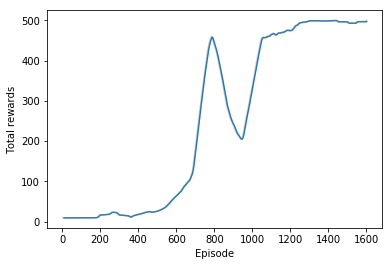

In [28]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

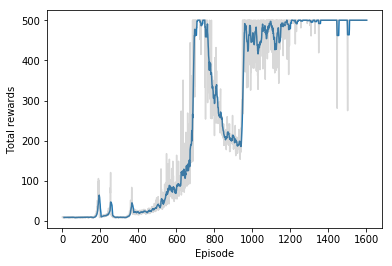

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

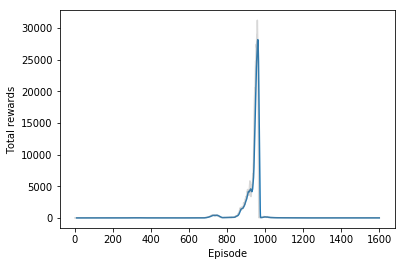

In [31]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
# Creating a gym env
import gym

# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action, _ = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.